In [1]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path 
sys.path.append('/home/aesgeorges/LaGonaveFM/')
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl
import geopandas as gpd

import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray as rxr

import fiona
from shapely.geometry import shape

#from cmcrameri import cm as cmc

#  Analysis of Mangrove Retreat + Sea Level Rise ADCIRC Simulations

Featuring modded Hurricane Matthew Track v1

## Data Imports

In [2]:
scenario_r0 = 'Gonave_SLR_retreats/r0' # No Retreat (Close to 2010 cover)
scenario_r1 = 'Gonave_SLR_retreats/r1' # Light Retreat (Close to 2020 cover)
scenario_r2 = 'Gonave_SLR_retreats/r2'
scenario_r3 = 'Gonave_SLR_retreats/r3'

root = f'../sims/'

cities_extents = '../datasets/other/cities.shp'

In [3]:
# Read the shapefile using fiona
with fiona.open(cities_extents, 'r') as src:
    cities = pd.DataFrame([feature['properties'] for feature in src])
    cities['geometry'] = [shape(feature['geometry']) for feature in src]

cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry')
cities_gdf

,id,geometry
0,0,"POLYGON ((-72.65229 19.30147, -72.65162 19.301..."
1,1,"POLYGON ((-72.60486 19.31420, -72.60363 19.314..."
2,3,"POLYGON ((-72.69655 19.45433, -72.69628 19.455..."


In [4]:
r0_s0_path = f'{root}{scenario_r0}/S0/hotstart/maxele.63.nc'
r0_s0_data = netcdf.Dataset(r0_s0_path, 'r') # Baseline Sim

r1_s0_path = f'{root}{scenario_r1}/S0/hotstart/maxele.63.nc'
r1_s0_data = netcdf.Dataset(r1_s0_path, 'r') # Mangrove S0 Medium Retreat Sim

r2_s0_path = f'{root}{scenario_r2}/S0/hotstart/maxele.63.nc'
r2_s0_data = netcdf.Dataset(r2_s0_path, 'r') # Mangrove S0 Medium Retreat Sim

r3_s0_path = f'{root}{scenario_r3}/S0/hotstart/maxele.63.nc'
r3_s0_data = netcdf.Dataset(r3_s0_path, 'r') # Mangrove S0 Heavy Retreat Sim

## Functions

In [5]:
def scenario_data(scenario, year):
    r0_path = f'{root}{scenario_r0}/{scenario}_{year}/hotstart/maxele.63.nc'
    r0_data = netcdf.Dataset(r0_path, 'r') # Baseline Sim

    r1_path = f'{root}{scenario_r1}/{scenario}_{year}/hotstart/maxele.63.nc'
    r1_data = netcdf.Dataset(r1_path, 'r') # Mangrove S0 Medium Retreat Sim

    r2_path = f'{root}{scenario_r2}/{scenario}_{year}/hotstart/maxele.63.nc'
    r2_data = netcdf.Dataset(r2_path, 'r') # Mangrove S0 Medium Retreat Sim

    r3_path = f'{root}{scenario_r3}/{scenario}_{year}/hotstart/maxele.63.nc'
    r3_data= netcdf.Dataset(r3_path, 'r') # Mangrove S0 Heavy Retreat Sim

    return r0_data, r1_data, r2_data, r3_data

In [6]:
def plot_flood_extent(run, ax, color):
    tri = mpl.tri.Triangulation(run['x'][:].data, run['y'][:].data, run['element'][:,:] - 1)
    aux = run.variables['zeta_max'][:].data

    ax.tricontour(tri, aux, levels=0, colors=color, extend='neither')
    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

In [7]:
def plot_flood_extent_comparisons(r0_data, r1_data, r2_data, r3_data, title_scene):
    fig, ax = plt.subplots(figsize = (10,6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

    custom_gradient = ["#0004FF", "#30c67c", "#FF930F", "#FF0000"]

    plot_flood_extent(r0_data, ax, custom_gradient[0])
    plot_flood_extent(r1_data, ax, custom_gradient[1])
    plot_flood_extent(r2_data, ax, custom_gradient[2])
    plot_flood_extent(r3_data, ax, custom_gradient[3])

    ax.legend(handles=[mpl.lines.Line2D([], [], color=custom_gradient[0], label=f'R0 S0 - Baseline'),
                    mpl.lines.Line2D([], [], color=custom_gradient[1], label=f'R1 S0 - Light Retreat'),
                    mpl.lines.Line2D([], [], color=custom_gradient[2], label=f'R2 S0 - Medium Retreat'),     
                    mpl.lines.Line2D([], [], color=custom_gradient[3], label=f'R3 S0 - Heavy Retreat')], loc='upper left')

    cities_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
            ax.text(x, y, str(label), fontsize=10, color='black', ha='center', va='center', zorder=11)

    ax.set_xlim(-72.85, -72.6)
    ax.set_ylim(19.25, 19.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False

    coast = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    ax.add_feature(cf.LAKES)
    ax.add_feature(coast)

    ax.set_title(f'Inundation Extents for Different Mangrove Retreats - {title_scene}', fontsize=12)

In [8]:
import math

def calculate_pixel_area(lat, pixel_width_deg, pixel_height_deg):
    """Calculate area of a WGS84 pixel in square meters given its latitude and dimensions in degrees"""
    # WGS84 ellipsoid parameters
    a = 6378137.0  # Semi-major axis (equatorial radius) in meters
    b = 6356752.314245  # Semi-minor axis (polar radius) in meters
    e_sq = 1 - (b*b)/(a*a)  # Eccentricity squared
    
    # Calculate meters per degree
    lon_meters_per_deg = (math.pi/180) * a * math.cos(math.radians(lat)) / math.sqrt(1 - e_sq * math.pow(math.sin(math.radians(lat)), 2))
    lat_meters_per_deg = (math.pi/180) * a * (1 - e_sq) / math.pow(1 - e_sq * math.pow(math.sin(math.radians(lat)), 2), 1.5)
    
    # Calculate area
    return pixel_width_deg * lon_meters_per_deg * pixel_height_deg * lat_meters_per_deg

def calculate_flood_area(raster_path):
    # Open the raster file
    with rio.open(raster_path) as src:
        # Get the transform and dimensions
        transform = src.transform
        height = src.height
        width = src.width
        
        # Extract the pixel width and height in degrees
        pixel_width_deg = abs(transform[0])
        pixel_height_deg = abs(transform[4])
        
        # Read the raster data
        data = src.read(1).astype(float)  # Assuming single band raster and we're working with float type that can handle NaN
        data[data == -99999.0] = np.nan
        
        # Create a mask of valid (non-NaN) pixels
        valid_mask = ~np.isnan(data)
        valid_count = np.sum(valid_mask)
        
        # Get bounds
        bounds = src.bounds
        
        # Calculate total area of non-NaN pixels
        total_area = 0
        
        # Create an array of latitudes for each row
        # First, get the latitude of the top edge
        top_lat = bounds.top
        
        # For each row, calculate the latitude at the center of the pixels
        for row in range(height):
            # Calculate latitude at the center of this row of pixels
            # (subtract half a pixel to get to the center of the first pixel,
            # then subtract the appropriate number of pixels for the current row)
            row_lat = top_lat - (pixel_height_deg * (row + 0.5))
            
            # Calculate pixel area at this latitude
            pixel_area = calculate_pixel_area(row_lat, pixel_width_deg, pixel_height_deg)
            
            # Count valid pixels in this row and add their area to the total
            valid_pixels_in_row = np.sum(valid_mask[row, :])
            total_area += valid_pixels_in_row * pixel_area
        
        #print(f"Number of valid (non-NaN) pixels: {valid_count}")
        #print(f"Total area of valid pixels: {total_area:.2f} square meters ({total_area/1000000:.4f} square kilometers)")

        return total_area, valid_count

In [9]:
import matplotlib.patheffects as path_effects

def compute_diff(path_base_mangrove, path_base_nomangrove):
    base_mangrove = rxr.open_rasterio(path_base_mangrove)
    base_nomangrove = rxr.open_rasterio(path_base_nomangrove)

    base_mangrove = base_mangrove.where(base_mangrove != base_mangrove.attrs['_FillValue'], np.nan)
    base_nomangrove = base_nomangrove.where(base_nomangrove != base_nomangrove.attrs['_FillValue'], np.nan)

    diff = base_mangrove - base_nomangrove
    return diff


def plot_diff(diff, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
    # Convert from NGVD29 to NAVD88 using an approximate offset (https://pubs.usgs.gov/sir/2010/5040/section.html)

    norm = colors.TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())

    n = diff.plot(ax=ax, cmap=cmocean.cm.balance, zorder=10, norm=norm, cbar_kwargs={'label': 'Difference in flood depth [m]'})
    cbar = n.colorbar
    cbar.set_label('Difference in flood depth [m]', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_yscale('linear')

    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        t = ax.text(
            x, y, str(label),
            fontsize=10,
            color='white',
            ha='center',
            va='center',
            zorder=11,
        )
        t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

    ax.set_xlim(-72.85, -72.58)
    ax.set_ylim(19.23, 19.5)

    print(diff.min(), diff.max())  

    ax.set_title(title, fontsize=16)

    #coastline = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    #ax.add_feature(coastline, zorder=1)
    #ax.add_feature(cf.BORDERS, linestyle='--', alpha=0.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False
    # Export the plot with a transparent background
    plt.savefig(f"exports/figures/{title}.png", dpi=600, bbox_inches='tight', transparent=True)
    
    return fig, ax

In [50]:
from rasterio.features import dataset_features

def plot_inter_extents(path1, path2, cover_base, cover, title_scene, title):
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
    
    ras1 = rxr.open_rasterio(path1).squeeze()
    ras2 = rxr.open_rasterio(path2).squeeze()
    
    test1 = ras1.where(ras1 != ras1.attrs['_FillValue'], 0)
    test2 = ras2.where(ras2 != ras2.attrs['_FillValue'], 0)
    
    ras1 = ras1.where(ras1 != ras1.attrs['_FillValue'], np.nan)
    ras2 = ras2.where(ras2 != ras2.attrs['_FillValue'], np.nan)
 
    diff_test = test2 - test1
    diff_test = diff_test.where(diff_test != 0, np.nan)
    diff_mask = diff_test.where(~np.isnan(ras1))

    norm = colors.TwoSlopeNorm(vmin=np.nanmin(diff_test), vcenter=0, vmax=np.nanmax(diff_test))
    m = diff_test.plot(ax=ax, cmap="PuOr", zorder=5, norm=norm, cbar_kwargs={'label': 'Difference in flood depth [m]'})
    cbar = m.colorbar

    with rio.open(path1) as src:
        outline = gpd.GeoDataFrame.from_features(dataset_features(src, bidx=1, as_mask=True, geographic=False, band=False))
    with rio.open(path2) as src:
        outline2 = gpd.GeoDataFrame.from_features(dataset_features(src, bidx=1, as_mask=True, geographic=False, band=False))

    # Mask outline2 with outline: keep only the parts of outline2 that intersect outline
    extra_flooding = gpd.overlay(outline, outline2, how='symmetric_difference')
    extra_flooding.plot(ax=ax, edgecolor='red', facecolor='none', zorder=5, linewidth=0.7)

    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']

    cover_base.plot(ax=ax, edgecolor='black', facecolor='none', linestyle='--', zorder=10)
    cover.plot(ax=ax, edgecolor='limegreen', facecolor='none', alpha=0.1, linestyle='-', zorder=10)
    cover.plot(ax=ax, edgecolor='limegreen', facecolor='none', linestyle='-', zorder=10)

    cover_loss = gpd.overlay(gpd.GeoDataFrame(geometry=cover), gpd.GeoDataFrame(geometry=cover_base), how='symmetric_difference')
    cover_loss.plot(ax=ax, edgecolor='none', hatch='///', facecolor='red', alpha=0.1, zorder=10)
    

    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        t = ax.text(
            x, y, str(label),
            fontsize=10,
            color='white',
            ha='center',
            va='center',
            zorder=11,
        )
        t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

    ax.set_xlim(-72.8, -72.58)
    ax.set_ylim(19.23, 19.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title(title, fontsize=16)

    
    plt.savefig(f"exports/figures/{title}.png", dpi=600, bbox_inches='tight', transparent=True)
    return diff_test

## Raw ADCIRC FLood Extents

In [11]:
scenario = 'SSP5'
year = '2100'

r0_data, r1_data, r2_data, r3_data = scenario_data(scenario, year)

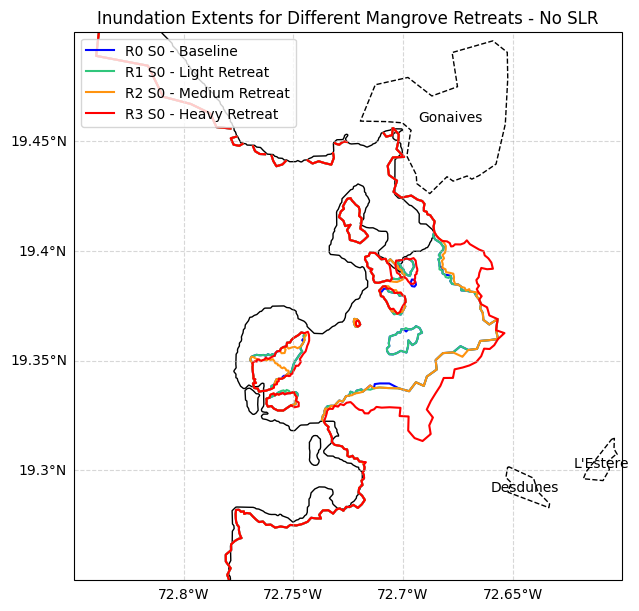

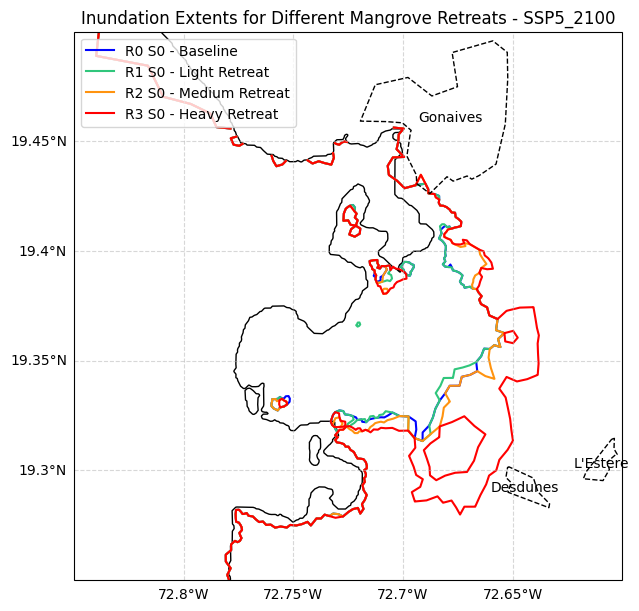

In [12]:
plot_flood_extent_comparisons(r0_s0_data, r1_s0_data, r2_s0_data, r3_s0_data, 
                              title_scene = 'No SLR')
plot_flood_extent_comparisons(r0_data, r1_data, r2_data, r3_data,
                              title_scene = f'{scenario}_{year}')

## Interpolated Flooding Inundation Stats

In [13]:
horizons = ['2030', '2100']
scenarios = ['ssp2', 'ssp5']   
retreats = ['r0', 'r1', 'r2', 'r3']

results_root = f'{root}Gonave_SLR_retreats/results/'

tail = '_flood_depths_exported.tif'

In [15]:
# s0 as first column
inundations = pd.DataFrame(index=horizons, columns=['s0'] + scenarios)

for scenario in scenarios:
    inun = []
    base = f'{results_root}{retreats[0]}/{retreats[0]}_s0{tail}'
    area, valid_n = calculate_flood_area(base)
    area = area / 1000000 # Convert to km²
    inundations['s0'] = area  # Append the area for the baseline scenario
    for year in horizons:
        path = f'{results_root}{retreats[0]}/{retreats[0]}_{scenario}_{year}{tail}'
        #print(path)
        area, valid_n = calculate_flood_area(path)
        area = area / 1000000 # Convert to km²
        inun.append(area)
    inundations[scenario] = inun

inundations

,s0,ssp2,ssp5
2030,152.322831,154.404396,154.404396
2100,152.322831,176.328852,179.438109


In [16]:
pct_change_from_base = inundations.divide(inundations.iloc[0], axis="columns") - 1
pct_change_from_base.head()

,s0,ssp2,ssp5
2030,0.0,0.000000,0.000000
2100,0.0,0.141994,0.162131


In [17]:
pct_change_yrly = inundations.pct_change(axis=0) * 100
pct_change_yrly

,s0,ssp2,ssp5
2030,NaN,NaN,NaN
2100,0.0,14.199373,16.213083


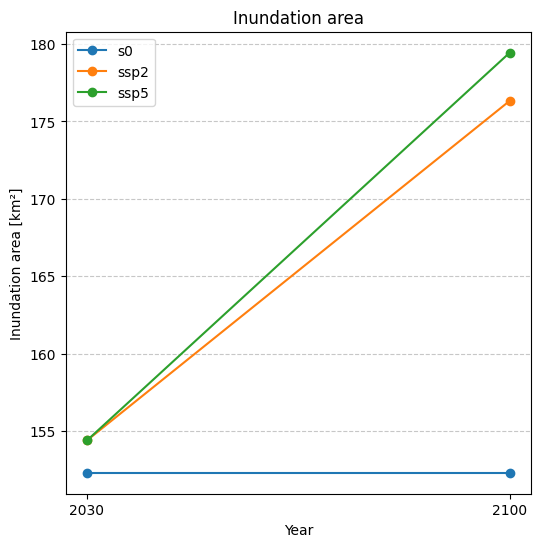

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
inundations.plot(ax=ax, marker='o')
ax.set_title('Inundation area')
ax.set_ylabel('Inundation area [km²]')
ax.set_xlabel('Year')
ax.set_xticks(range(len(horizons)))
ax.set_xticklabels(horizons)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

## Interpolated Flooding Inundation Maps

### Retreats vs SLR 
(Looking at the flooding extent over time for each retreat scenario)

In [20]:
covers_gdf = gpd.GeoDataFrame(index=retreats, columns=['geometry'])

cover_path_tails = ['_retreat_light.shp', '_retreat_medium.shp', '_retreat_heavy.shp']
cover_root = '../datasets/mangrove_covers/refined/mangrove_polygon'

base_cover_path = '../datasets/mangrove_covers/refined/base/mangrove_polygon_refined.shp'
with fiona.open(base_cover_path, 'r') as src:
        base_cover = pd.DataFrame([feature['properties'] for feature in src])
        base_cover['geometry'] = [shape(feature['geometry']) for feature in src]
covers_gdf.iloc[0] = base_cover.iloc[0]['geometry']

for i, retreat in enumerate(cover_path_tails):
    path = f'{cover_root}{retreat}'
    with fiona.open(path, 'r') as src:
        cover = pd.DataFrame([feature['properties'] for feature in src])
        cover['geometry'] = [shape(feature['geometry']) for feature in src]
    cover_gdf = gpd.GeoDataFrame(cover, geometry='geometry')
    covers_gdf.iloc[i+1] = cover['geometry'].iloc[0]  # Assuming each retreat has one geometry
covers_gdf

,geometry
r0,"POLYGON ((-72.69583 19.39900, -72.69393 19.399..."
r1,"MULTIPOLYGON (((-72.71323 19.38336, -72.71325 ..."
r2,"MULTIPOLYGON (((-72.76563 19.27981, -72.76313 ..."
r3,"MULTIPOLYGON (((-72.77298 19.27977, -72.77288 ..."


In [21]:
i = 0
path_r0_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r0_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r0_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r0_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r0_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

In [22]:
i = 1 # r2
path_r1_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r1_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r1_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r1_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r1_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

In [23]:
i = 2 # r2
path_r2_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r2_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r2_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r2_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r2_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

In [24]:
i = 3
path_r3_s0 = f'{results_root}{retreats[i]}/{retreats[i]}_s0{tail}'
path_r3_ssp2_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2030{tail}'
path_r3_ssp2_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp2_2100{tail}'
path_r3_ssp5_2030 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2030{tail}'
path_r3_ssp5_2100 = f'{results_root}{retreats[i]}/{retreats[i]}_ssp5_2100{tail}'

#### S0 - No SLR

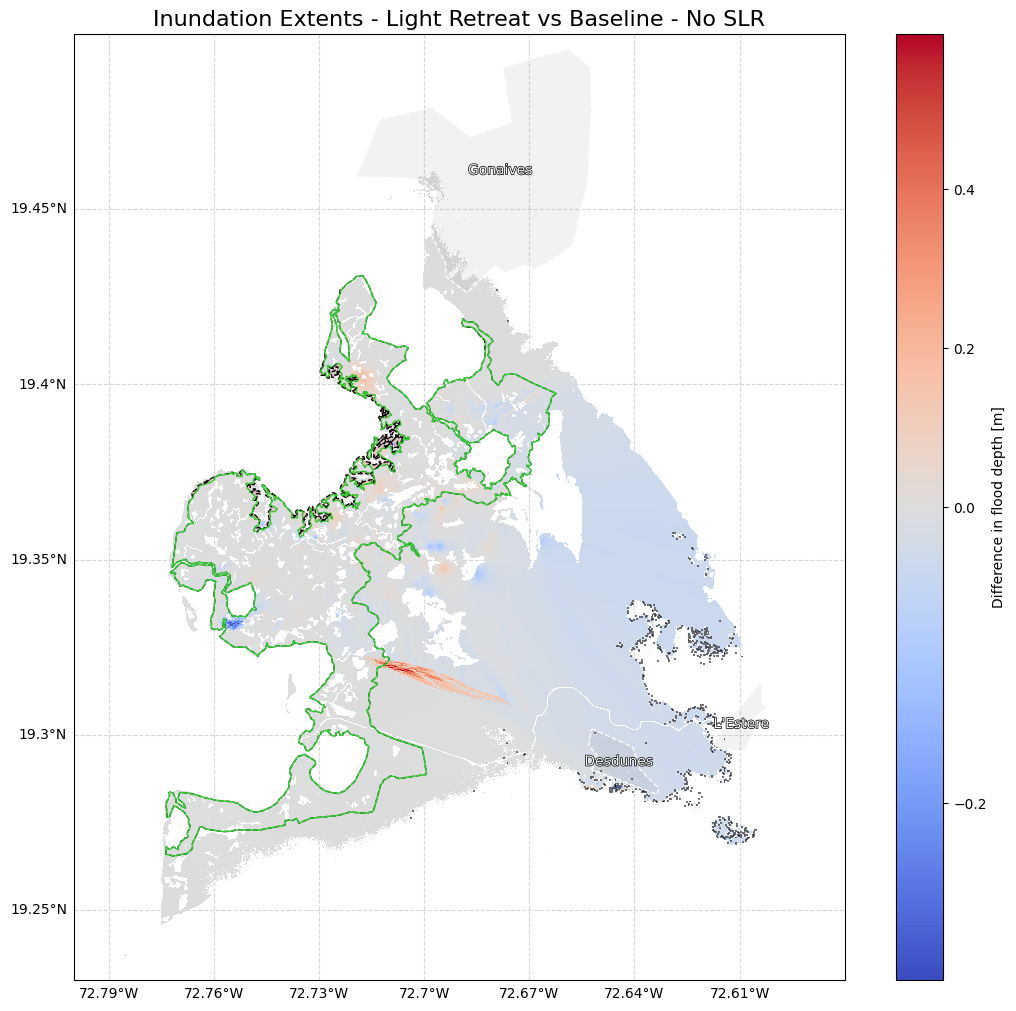

In [25]:
# R0 
title_scene = 'S0'
title = f'Inundation Extents - Light Retreat vs Baseline - No SLR'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])

diff_test = plot_inter_extents(path_r0_s0, path_r1_s0, cover_base, cover, title_scene, title)

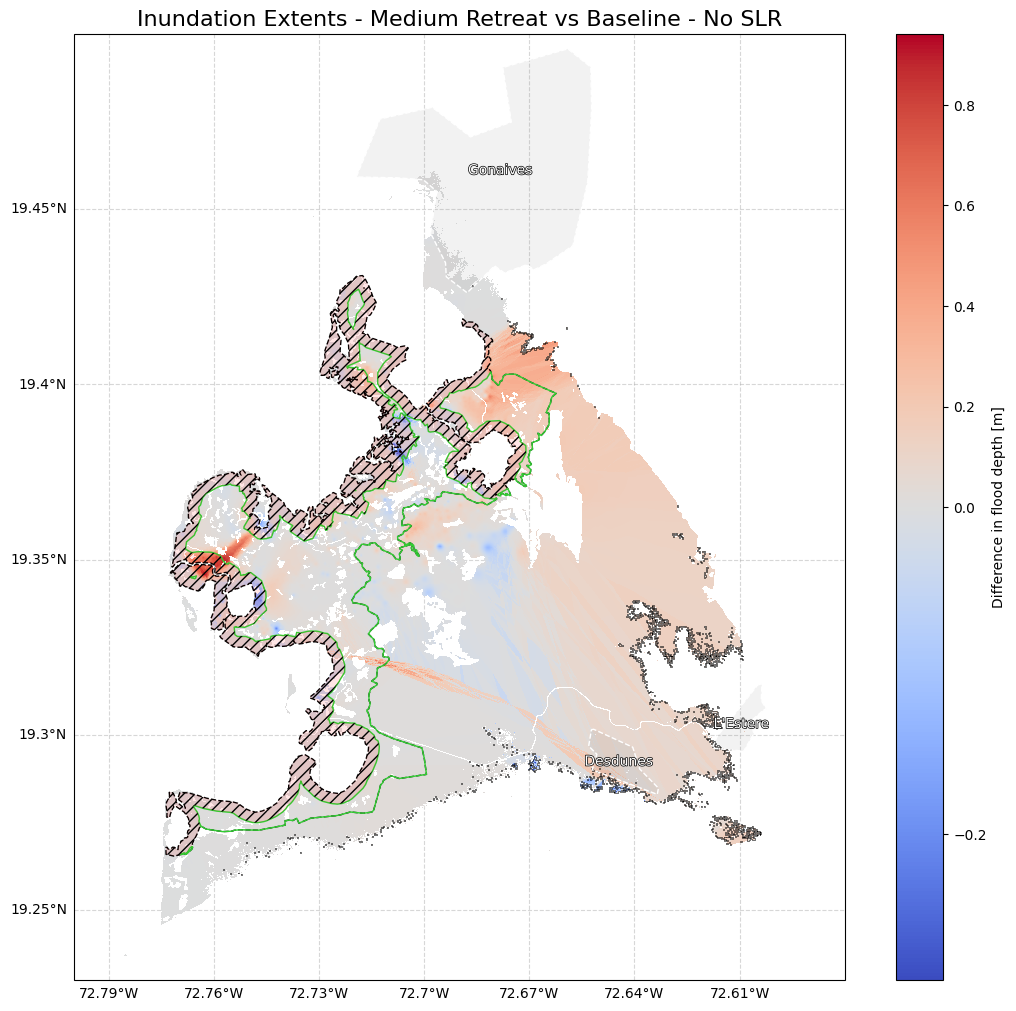

In [26]:
# R0 
title_scene = 'S0'
title = f'Inundation Extents - Medium Retreat vs Baseline - No SLR'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])

diff_test = plot_inter_extents(path_r0_s0, path_r2_s0, cover_base, cover, title_scene, title)

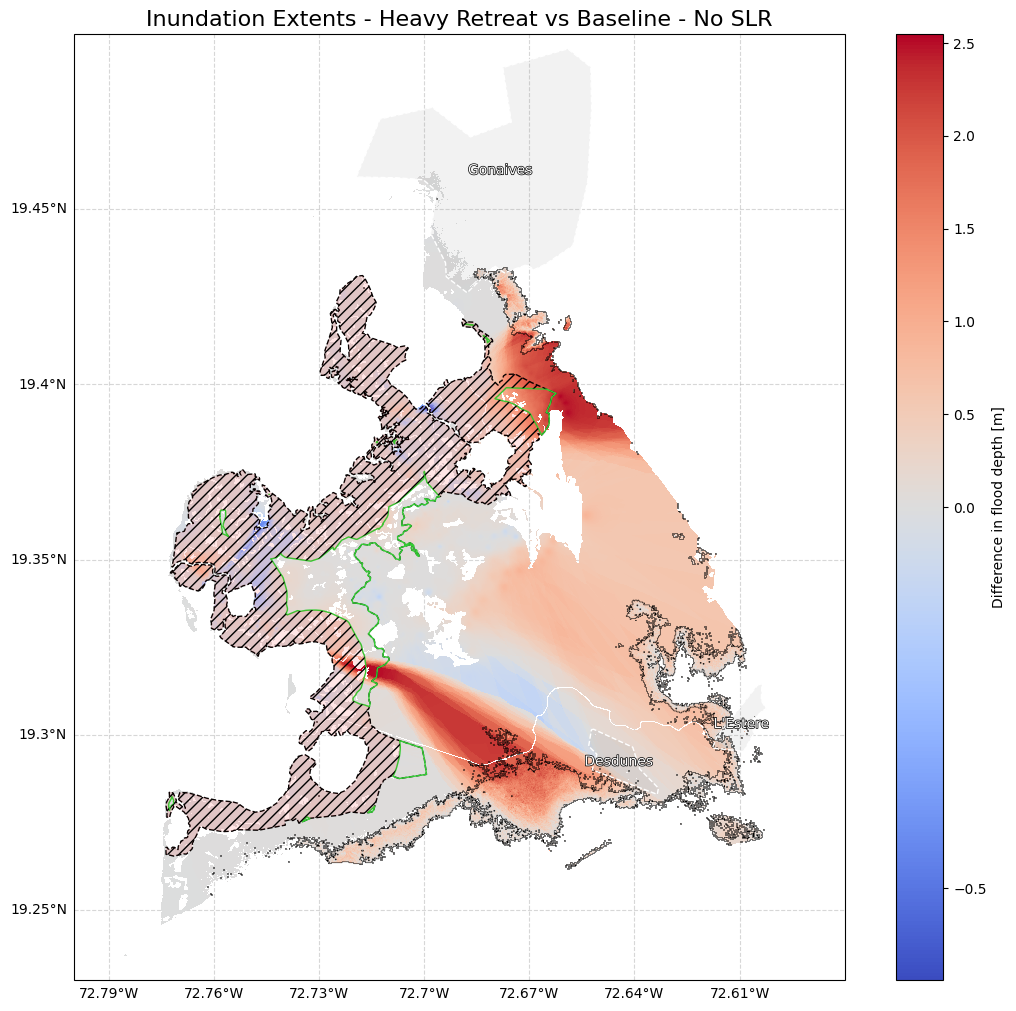

In [27]:
# R0 
title_scene = 'S0'
title = f'Inundation Extents - Heavy Retreat vs Baseline - No SLR'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

diff_test = plot_inter_extents(path_r0_s0, path_r3_s0, cover_base, cover, title_scene, title)

#### SSP2-2100

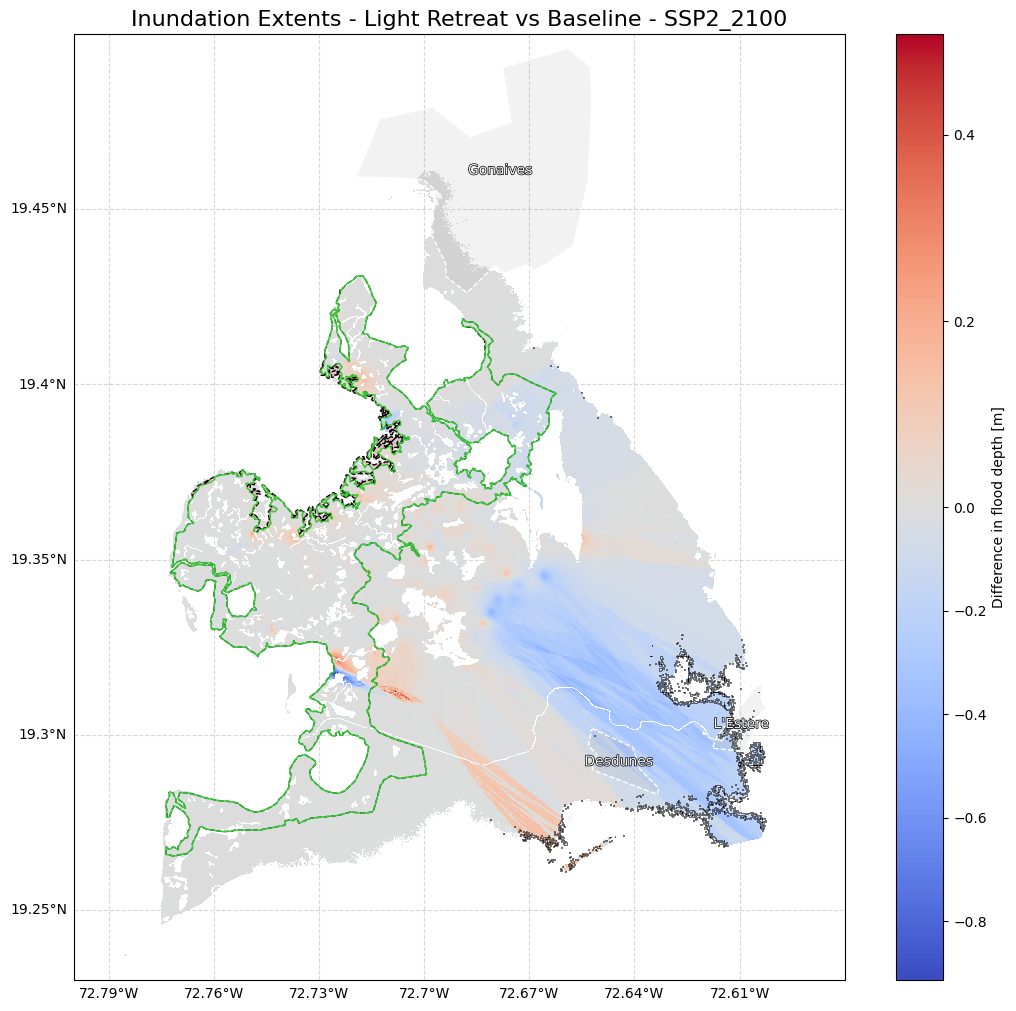

In [28]:
# R0 
title_scene = 'SSP2_2100'
title = f'Inundation Extents - Light Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp2_2100, path_r1_ssp2_2100, cover_base, cover, title_scene, title)

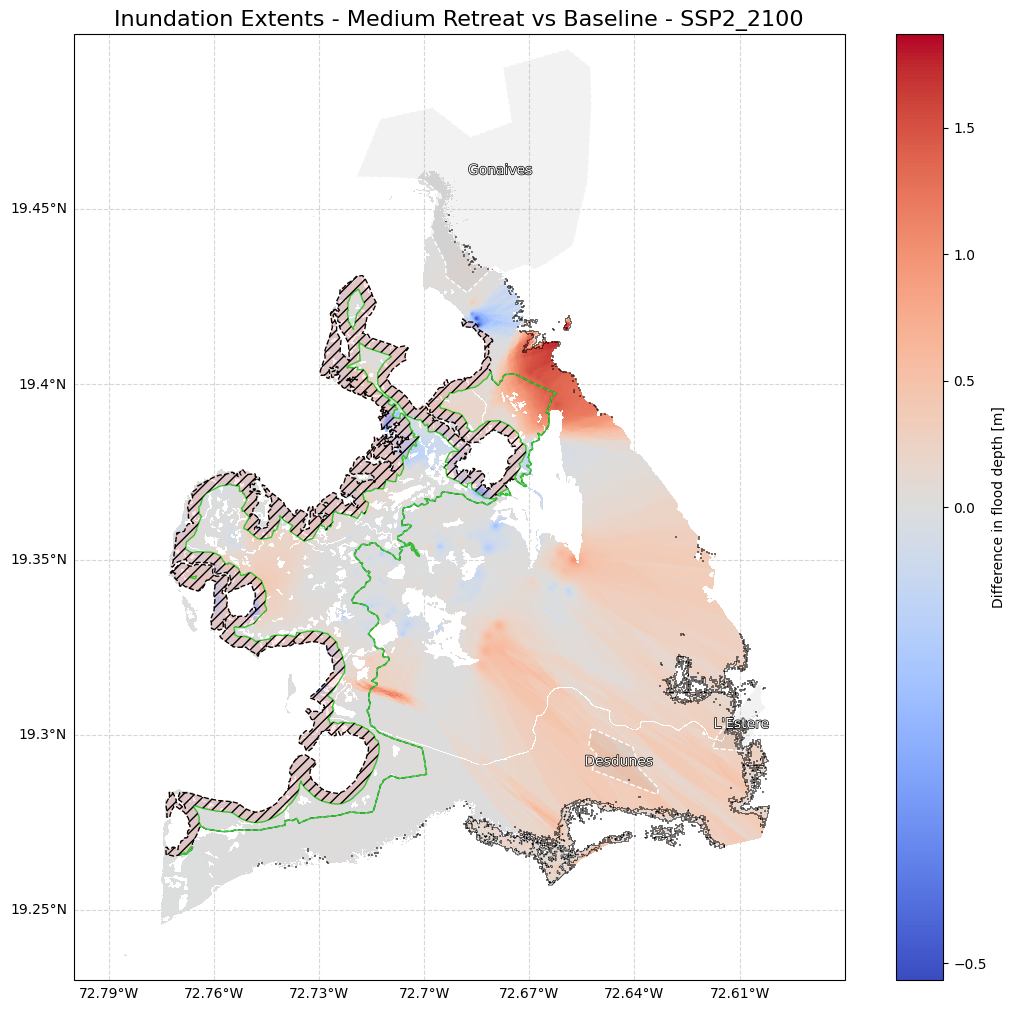

In [29]:
# R0 
title_scene = 'SSP2_2100'
title = f'Inundation Extents - Medium Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp2_2100, path_r2_ssp2_2100, cover_base, cover, title_scene, title)

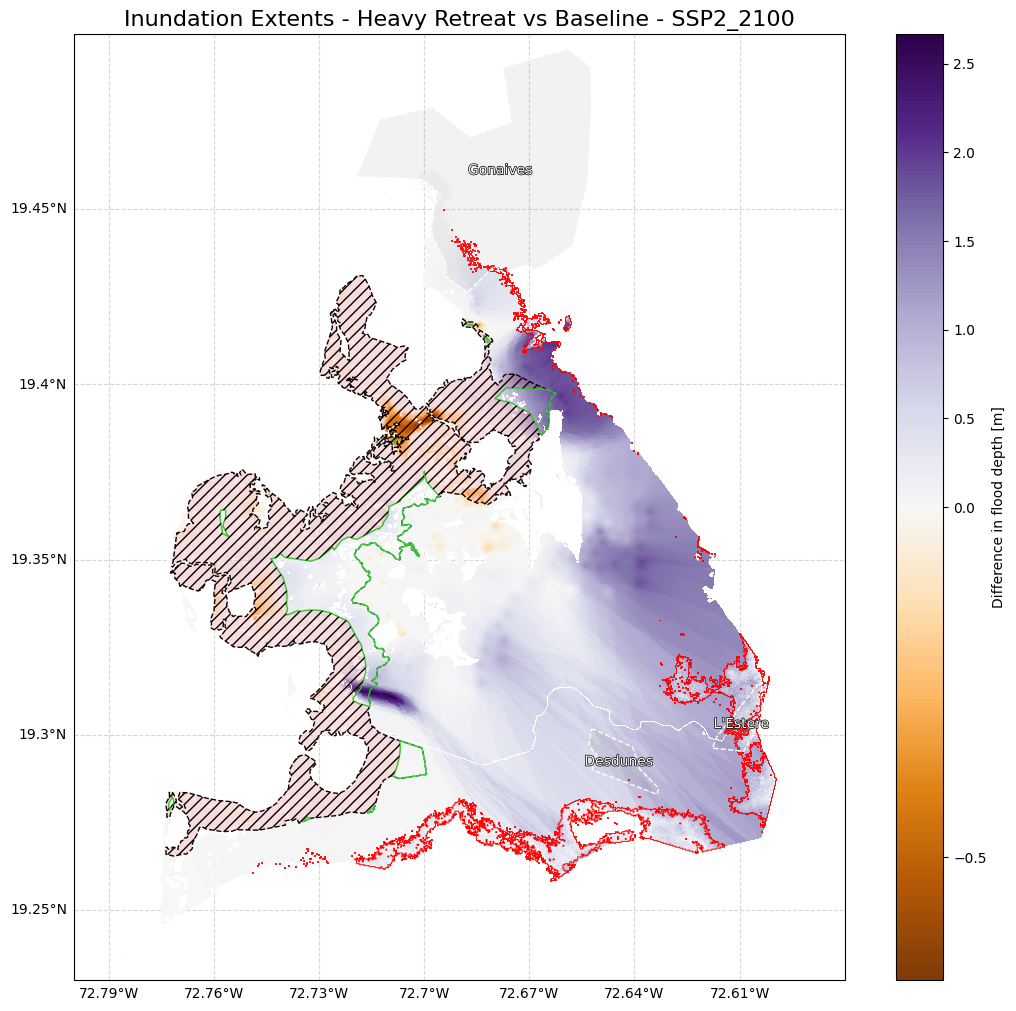

In [54]:
# R0 
title_scene = 'SSP2_2100'
title = f'Inundation Extents - Heavy Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp2_2100, path_r3_ssp2_2100, cover_base, cover, title_scene, title)

#### SSP5-2100

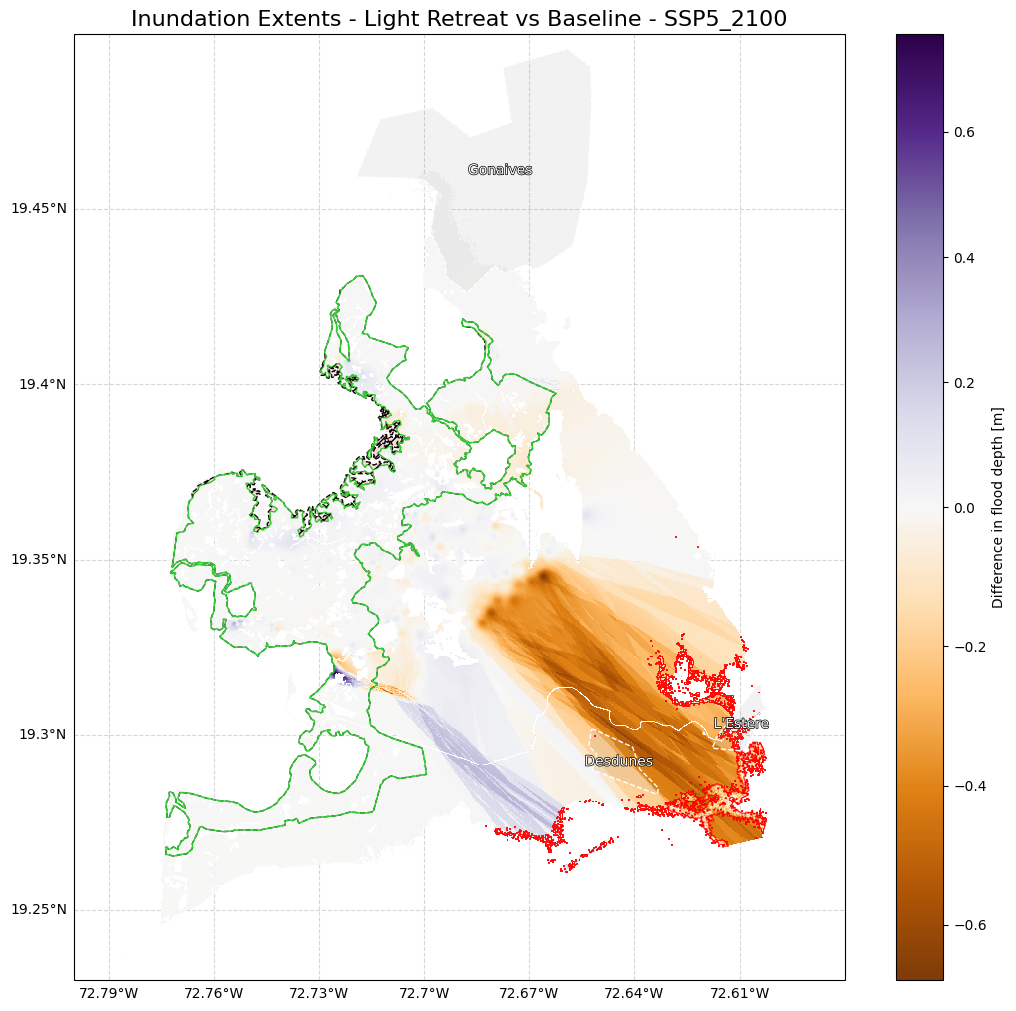

In [53]:
# R0 
title_scene = 'SSP5_2100'
title = f'Inundation Extents - Light Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r1']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp5_2100, path_r1_ssp5_2100, cover_base, cover, title_scene, title)

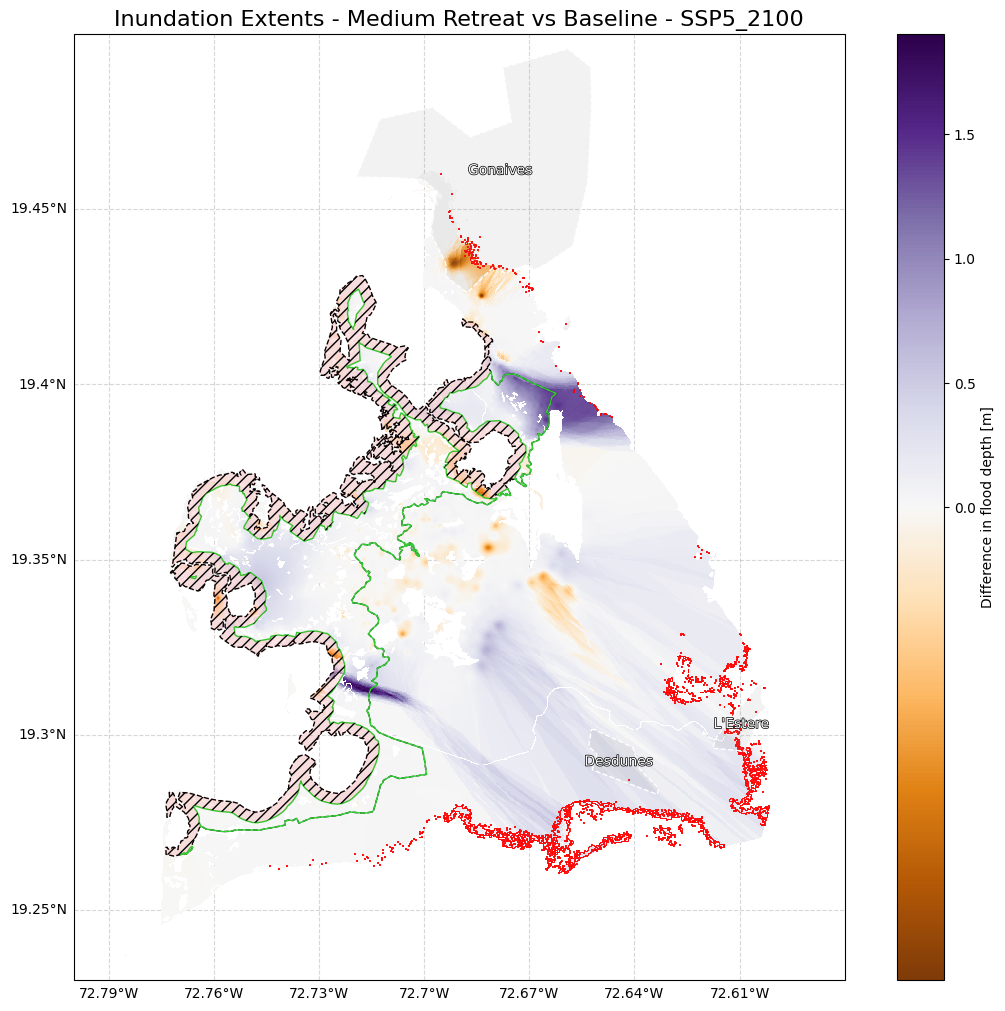

In [52]:
title_scene = 'SSP5_2100'
title = f'Inundation Extents - Medium Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r2']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp5_2100, path_r2_ssp5_2100, cover_base, cover, title_scene, title)

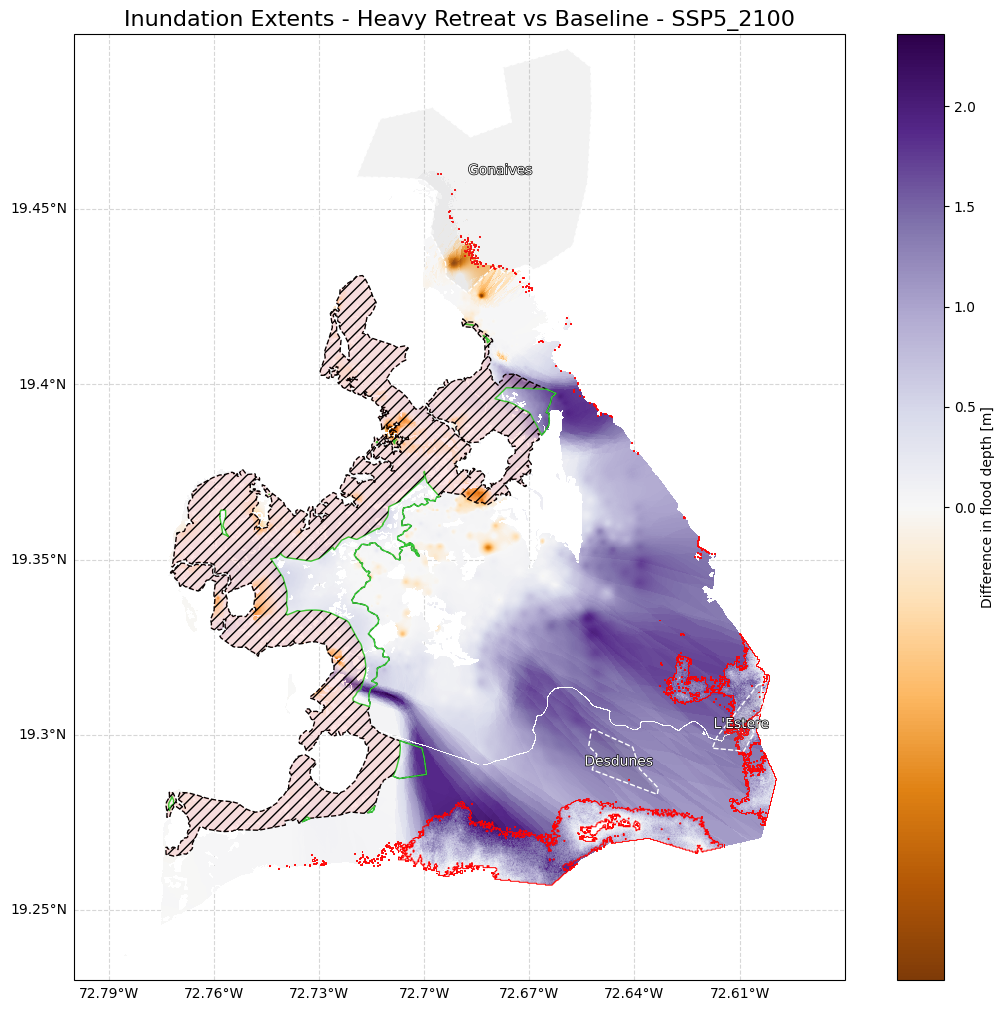

In [51]:
title_scene = 'SSP5_2100'
title = f'Inundation Extents - Heavy Retreat vs Baseline - {title_scene}'
cover_base = gpd.GeoSeries([covers_gdf.loc[f'r0']['geometry']])
cover = gpd.GeoSeries([covers_gdf.loc[f'r3']['geometry']])

diff_test = plot_inter_extents(path_r0_ssp5_2100, path_r3_ssp5_2100, cover_base, cover, title_scene, title)

<xarray.DataArray ()> Size: 4B
array(-3.0018013, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(0.27331936, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0


<GeoAxesSubplot: title={'center': 'Difference in flood depth [m] - Baseline vs SSP5_2100 Light Retreat'}, xlabel='x', ylabel='y'>

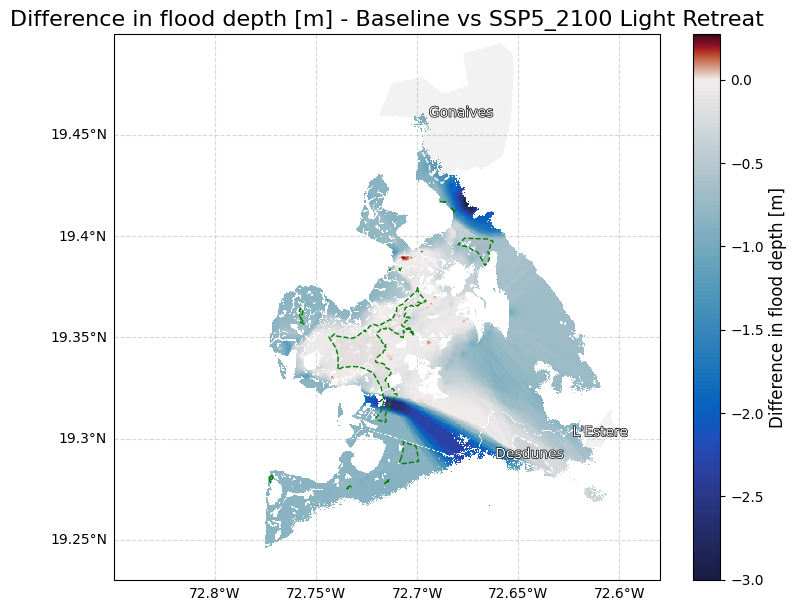

In [34]:
diff = compute_diff(path_r1_s0, path_r1_ssp5_2100)
fig, ax = plot_diff(diff, f'Difference in flood depth [m] - Baseline vs SSP5_2100 Light Retreat')

cover = gpd.GeoSeries([covers_gdf.loc[f'r{i}']['geometry']])
cover.plot(ax=ax, edgecolor='green', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
cover.plot(ax=ax, edgecolor='green', facecolor='none', linestyle='--', zorder=10)

#### R2 - Medium Retreat